In [1]:
"Frank2019_clean_1.csv"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.decomposition import PCA


In [2]:
# read data in google drive: you may need to replace the below path with your path in google drive
df_2019 = pd.read_csv('Frank2019_clean_1.csv')

df_2019.drop(['Unnamed: 0'],axis = 1,inplace= True)
df_2019

X = df_2019.drop('SalePrice',axis = 1)
y = df_2019['SalePrice']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)
X_scale = pd.DataFrame(X_scale,columns=X.columns)
X_scale

# split data into training and testing sets
X_train_valid,X_test,y_train_valid,y_test = train_test_split(X_scale,y,test_size = 0.2, random_state = 42)
# reset the index
for i in [X_train_valid,X_test]:
  i.reset_index(inplace = True, drop = True)
y_train_valid = y_train_valid.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

# split training data into train and validation sets
X_train,X_valid,y_train,y_valid = train_test_split(X_train_valid,y_train_valid,test_size = 0.2, random_state = 42)
for i in [X_train,X_valid]:
  i.reset_index(inplace = True, drop = True)
y_train = y_train.reset_index(drop = True)
y_valid = y_valid.reset_index(drop = True)

X_train.shape,X_test.shape,X_valid.shape

X_train_valid_raw = X_train_valid.copy()
X_train_raw = X_train.copy()
X_valid_raw = X_valid.copy()
X_test_raw = X_test.copy()

# (1) non-spatial features
X_train20 = X_train.drop(['X','Y'],axis = 1)
X_valid20 = X_valid.drop(['X','Y'],axis = 1)
X_test20 = X_test.drop(['X','Y'],axis = 1)
X_train_valid20 = X_train_valid.drop(['X','Y'],axis = 1)

# (2) only XY
X_train_XYonly = X_train[['X','Y']]
X_valid_XYonly = X_valid[['X','Y']]
X_test_XYonly = X_test[['X','Y']]
X_train_valid_XYonly = X_train_valid[['X','Y']]

# (3) features + XY
X_train_20XY = X_train.copy()
X_valid_20XY = X_valid.copy()
X_test_20XY = X_test.copy()
X_train_valid_20XY = X_train_valid.copy()



In [3]:
# step 0: a helper function
# -- data proprocessing: subset spatial, nonsptial data
def input_process(X_train,X_test):
  # spatial cols
  X_train_space = X_train[['X','Y']].to_numpy()
  X_test_space = X_test[['X','Y']].to_numpy()

  # non-spatial cols
  X_train_Xs = X_train.drop(['X','Y'],axis = 1).to_numpy()
  X_test_Xs = X_test.drop(['X','Y'],axis = 1).to_numpy()
  if(X_train_Xs.shape[1]>20):  # do PCA if non-spatial features >20
    from sklearn.decomposition import PCA
    pca = PCA(n_components = 10)
    X_train_Xs = pca.fit_transform(X_train_Xs)
    X_test_Xs = pca.transform(X_test_Xs)
    print('number of pca for feature:',X_test_Xs.shape)

  return X_train_space,X_test_space,X_train_Xs,X_test_Xs

# step 1: calcualte the distance to find the nearest K indices
def cal_dist(X_train_space,X_test_space,X_train_Xs,X_test_Xs,ratio):

  # Calculating two distance matrices using numpy broadcasting technique
  #dist_space = np.sqrt(((X_train_space[:, :, None] - X_test_space[:, :, None].T) ** 2).sum(1)/X_train_space.shape[1])   # spatial distance
  #dist_Xs = np.sqrt(((X_train_Xs[:, :, None] - X_test_Xs[:, :, None].T) ** 2).sum(1)/X_train_Xs.shape[1])   # nonspatial distance
  dist_space = np.sqrt(((X_train_space[:, :, None] - X_test_space[:, :, None].T) ** 2).sum(1))/X_train_space.shape[1]   # spatial distance
  dist_Xs = np.sqrt(((X_train_Xs[:, :, None] - X_test_Xs[:, :, None].T) ** 2).sum(1))/X_train_Xs.shape[1]   # nonspatial distance
  # modified search distance
  distance = ratio *dist_space + (1-ratio)* dist_Xs

  return distance

# step 2: predict y_test using k nearest neighbors's value in y_train
def predict(y_train,X_test,distance, k):
    sorted_distance = np.argsort(distance, axis = 0) # sort the distance ascending, and return the indices
    y_pred = np.zeros(X_test.shape[0])
    for row in range(X_test.shape[0]):
      #y_pred[row] = y_train[sorted_distance[:,row][:k]].mean()   # simple mean
      y_pred[row] = np.average(y_train[sorted_distance[:,row][:k]], weights = 1.0/distance[sorted_distance[:,row][:k],row]) # weighted mean

    return y_pred



# step 3: tune parameters to find the best k and spatial ratio
# input-  dataframe: X_train,X_test,y_train,y_valid;
#         list: ratio_list -- spatial ratio
#               k_list -- Nearest K
# output- value: ratio_list, k_list

def tune_seknn(X_train,X_valid,y_train,y_valid,ratio_list, k_list):
  result_best = []
  k_best =[]

  # two for-loops to tune the hyperparameters: Spatial_ratio, K value
  X_train_space,X_valid_space,X_train_Xs,X_valid_Xs = input_process(X_train,X_valid)
  for ratio in ratio_list:
    print('---------- spatial ratio: ',ratio)
    if (ratio == 0):
      ratio = ratio+0.0000001
    # step 1: get distance
    distance = cal_dist(X_train_space,X_valid_space,X_train_Xs,X_valid_Xs, ratio)

    # step 2. use k to find the nearest neighbors to predict y value
    rmse_temp = []
    for k in k_list:
      #print('k=',k)
      y_pred = predict(y_train,X_valid,distance, k)

      rmse = np.sqrt(np.mean((y_valid - y_pred)**2))
      mae = metrics.mean_absolute_error(y_valid,y_pred)
      r2 = metrics.r2_score(y_valid,y_pred)
      rmse_temp.append([round(rmse,2),round(mae,2),round(r2,4)])

    print(rmse_temp)
    # for each ratio, get the best parameters
    i = 1 # Choose the metric criteria to choose the minimum;i=0 -- RMSE, i=1 -- MAE; i = 2 -- R^2
    min_index = np.argmin(rmse_temp,axis=0)[i]  # get the index for min RMSE
    print('Best k value:',k_list[min_index],'; best rmse:',rmse_temp[min_index])
    print()
    result_best.append(rmse_temp[min_index])
    k_best.append(k_list[min_index])

  # for all ratio, get the best parameters
  #print(k_best)
  best_ratio = ratio_list[np.argmin(result_best,axis=0)[i]]
  best_k = k_best[np.argmin(result_best,axis=0)[i]]
  print('Best ratio:',best_ratio)
  print('Best k:', best_k)

  print(result_best)
  plt.figure(figsize=(8,8))
  plt.plot(ratio_list,[row[1] for row in result_best],color='blue', linestyle='dashed',
           marker='o',markerfacecolor='red', markersize=7)
  plt.title('RMSE vs. spatial ratio')
  plt.xlabel('lambda')
  plt.ylabel('test error: MAE')

  return best_ratio, best_k

---------- spatial ratio:  0
[[np.float64(96757.84), 59510.23, 0.6329], [np.float64(93315.24), 56834.24, 0.6585], [np.float64(90294.02), 55388.74, 0.6803], [np.float64(88829.87), 54602.57, 0.6906], [np.float64(88366.78), 54505.78, 0.6938], [np.float64(88633.1), 54046.82, 0.6919], [np.float64(88548.35), 53911.05, 0.6925], [np.float64(88103.45), 53942.8, 0.6956], [np.float64(87612.65), 53865.54, 0.699], [np.float64(87216.13), 53754.71, 0.7017], [np.float64(87561.36), 53900.36, 0.6993], [np.float64(87747.47), 53843.31, 0.6981], [np.float64(87511.22), 53705.46, 0.6997], [np.float64(87288.04), 53608.54, 0.7012], [np.float64(87341.45), 53639.6, 0.7008], [np.float64(87559.66), 53756.38, 0.6993], [np.float64(87546.08), 53797.79, 0.6994], [np.float64(87448.86), 53785.3, 0.7001]]
Best k value: 15 ; best rmse: [np.float64(87288.04), 53608.54, 0.7012]

---------- spatial ratio:  0.2
[[np.float64(79124.72), 43163.27, 0.7545], [np.float64(78945.06), 42135.42, 0.7556], [np.float64(75883.51), 40923.1,

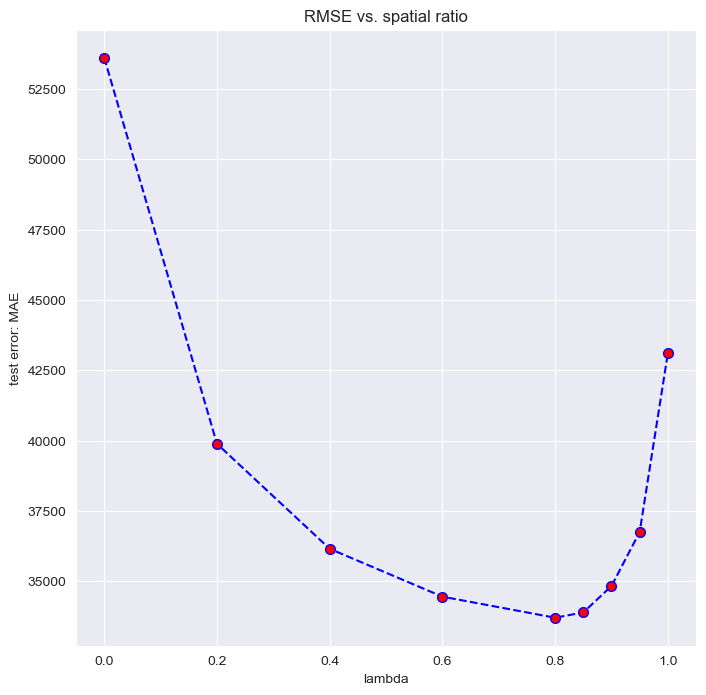

In [4]:
# Hyperparameter tuning
ratio_list = [0,0.2,0.4,0.6,0.8,0.85,0.9,0.95,1.0]
#ratio_list = [0,0.6,0.8,0.85,0.9,0.95,1.0]
k_list = [x for x in range(2,20,1)]
best_ratio,best_k = tune_seknn(X_train_20XY,X_valid_20XY,y_train,y_valid,ratio_list, k_list)

In [5]:
df_2019.shape

(16588, 15)